## IN3050/IN4050 Mandatory Assignment 2, 2022: Supervised Learning

### Rules

Before you begin the exercise, review the rules at this website: https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html , in particular the paragraph on cooperation. This is an individual assignment. You are not allowed to deliver together or copy/share source-code/answers with others. By submitting this assignment, you confirm that you are familiar with the rules and the consequences of breaking them.

### Delivery

**Deadline**: Friday, March 25, 2022, 23:59

Your submission should be delivered in Devilry. You may redeliver in Devilry before the deadline, but include all files in the last delivery, as only the last delivery will be read. You are recommended to upload preliminary versions hours (or days) before the final deadline.

### What to deliver?

You are recommended to solve the exercise in a Jupyter notebook, but you might solve it in a Python program if you prefer.

If you choose Jupyter, you should deliver the notebook. You should answer all questions and explain what you are doing in Markdown. Still, the code should be properly commented. The notebook should contain results of your runs. In addition, you should make a pdf of your solution which shows the results of the runs. (If you can't export: notebook -> latex -> pdf on your own machine, you may do this on the IFI linux machines.)

If you prefer not to use notebooks, you should deliver the code, your run results, and a pdf-report where you answer all the questions and explain your work.

Your report/notebook should contain your name and username.

Deliver one single zipped folder (.zip, .tgz or .tar.gz) which contains your complete solution.

Important: if you weren’t able to finish the assignment, use the PDF report/Markdown to elaborate on what you’ve tried and what problems you encountered. Students who have made an effort and attempted all parts of the assignment will get a second chance even if they fail initially. This exercise will be graded PASS/FAIL.

### Goals of the assignment
The goal of this assignment is to get a better understanding of supervised learning with gradient descent. It will, in particular, consider the similarities and differences between linear classifiers and multi-layer feed forward networks (multi-layer perceptron, MLP) and the differences and similarities between binary and multi-class classification. A main part will be dedicated to implementing and understanding the backpropagation algorithm. 

### Tools
The aim of the exercises is to give you a look inside the learning algorithms. You may freely use code from the weekly exercises and the published solutions. You should not use ML libraries like scikit-learn or tensorflow.

You may use tools like NumPy and Pandas, which are not specific ML-tools.

The given precode uses NumPy. You are recommended to use NumPy since it results in more compact code, but feel free to use pure python if you prefer. 

### Beware
There might occur typos or ambiguities. This is a revised assignment compared to earlier years, and there might be new typos. If anything is unclear, do not hesitate to ask. Also, if you think some assumptions are missing, make your own and explain them!

### Initialization

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn #for datasets

# Part 1: Linear classifiers
## Datasets
We start by making a synthetic dataset of 2000 datapoints and five classes, with 400 individuals in each class. (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html regarding how the data are generated.) We choose to use a synthetic dataset---and not a set of natural occuring data---because we are mostly interested in properties of the various learning algorithms, in particular the differences between linear classifiers and multi-layer neural networks together with the difference between binary and multi-class data.

When we are doing experiments in supervised learning, and the data are not already split into training and test sets, we should start by splitting the data. Sometimes there are natural ways to split the data, say training on data from one year and testing on data from a later year, but if that is not the case, we should shuffle the data randomly before splitting. (OK, that is not necessary with this particular synthetic data set, since it is already shuffled by default by scikit, but that will not be the case with real-world data.) We should split the data so that we keep the alignment between X and t, which may be achieved by shuffling the indices. We split into 50% for training, 25% for validation, and 25% for final testing. The set for final testing *must not be used* till the end of the assignment in part 3.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments. This is done by the `random_state` argument and the `rng = np.random.RandomState(2022)`.

In [4]:
from sklearn.datasets import make_blobs
X, t = make_blobs(n_samples=[400,400,400, 400, 400], centers=[[0,1],[4,1],[8,1],[2,0],[6,0]], 
                  n_features=2, random_state=2019, cluster_std=1.0)

In [5]:
indices = np.arange(X.shape[0])
rng = np.random.RandomState(2022)
rng.shuffle(indices)
indices[:10]

array([1018, 1295,  643, 1842, 1669,   86,  164, 1653, 1174,  747])

In [6]:
X_train = X[indices[:1000],:]
X_val = X[indices[1000:1500],:]
X_test = X[indices[1500:],:]
t_train = t[indices[:1000]]
t_val = t[indices[1000:1500]]
t_test = t[indices[1500:]]

Next, we will  make a second dataset by merging the two smaller classes in (X,t) and call the new set (X, t2). This will be a binary set.

In [7]:
t2_train = t_train >= 3
t2_train = t2_train.astype('int')
t2_val = (t_val >= 3).astype('int')
t2_test = (t_test >= 3).astype('int')

We can plot the two traing sets.

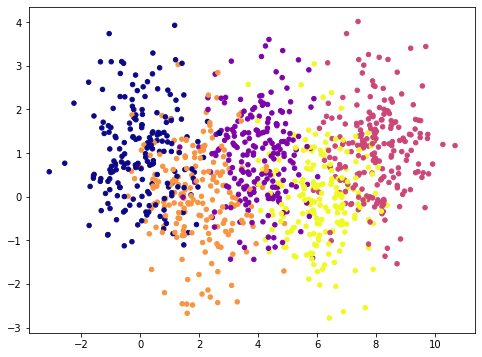

In [8]:
plt.figure(figsize=(8,6)) # You may adjust the size
plt.scatter(X_train[:, 0], X_train[:, 1], c=t_train, s=20.0, cmap='plasma')
plt.show()

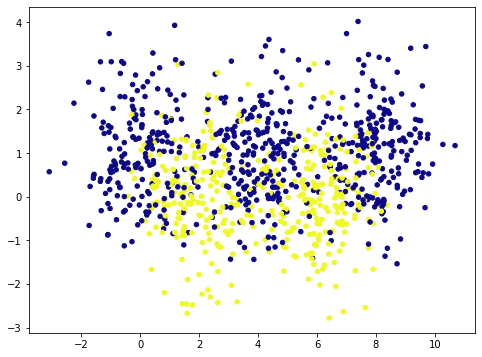

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=t2_train, s=20.0, cmap='plasma')
plt.show()

## Binary classifiers

### Linear regression
We see that that set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression. You may make your own implementation from scratch or start with the solution to the weekly exercise set 7, which we include here.

In [10]:
def add_bias(X,n=1):
    # Put bias in position 0
    sh = X.shape
    if len(sh) == 1:
        #X is a vector
        return np.concatenate([np.array([n]), X])
    else:
        # X is a matrix
        m = sh[0]
        bias = np.ones((m,1))*n # Makes a m*1 matrix of 1-s
        return np.concatenate([bias, X], axis  = 1) 

In [11]:
def mse(y, y_pred):
    sum_errors = 0.
    for i in range(0,len(y)):
        sum_errors += (y[i] - y_pred[i])**2
    mean_squared_error = sum_errors/len(y)
    return mean_squared_error


In [12]:
class NumpyClassifier():
    """Common methods to all numpy classifiers --- if any"""
    
    def accuracy(self,X_test, y_test, **kwargs):
        pred = self.predict(X_test, **kwargs)
        #print(pred.shape)
        if len(pred.shape) > 1:
            pred = pred[:,0]
        return np.sum(pred==y_test)/len(pred)

In [13]:
class NumpyLinRegClass(NumpyClassifier):

    def fit(self, X_train, t_train, eta = 0.075, epochs=300, loss_Diff= 0.00001):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
        
        (k, m) = X_train.shape

        X_train = add_bias(X_train)
        
        self.weights = weights = np.zeros(m+1)

        #print(X_train.shape, t_train.shape, weights.shape)
        
        diffCount = []
        
        min_Epochs = []


        for i in range(epochs):

            weights -= eta / k *  X_train.T @ (X_train @ weights - t_train)

            Error = mse(t_train, X_train @ weights)

            diffCount.append(Error)
            
            if abs(diffCount[i-1] - diffCount[i]) <= loss_Diff and i != 0:
                min_Epochs.append(i)
                
        return diffCount, min_Epochs

    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = z @ self.weights 
        return score >threshold


We can train and test a first classifier.

In [14]:
eta_best, epoch_best, acc_best = 0, 0, 0 

eta_values = np.linspace(0.001, 1, 25)

for eta in eta_values:
    for epoch in [1, 10, 20, 50, 60, 100]:
        cl = NumpyLinRegClass()
        cl.fit(X_train, t2_train, eta=eta, epochs=epoch)
        accu = cl.accuracy(X_val, t2_val)
        if accu > acc_best:
            acc_best = accu
            eta_best, epoch_best = eta, epoch

print(f'Eta: {eta_best}: Epochs: {epoch_best}: Accuracy: {acc_best}')


Eta: 0.042625: Epochs: 100: Accuracy: 0.644


The result is far from impressive. Experiment with various settings for the hyper-parameters, eta and epochs. Report how the accuracy vary with the hyper-parameter settings. When you are satisfied with the result, you may plot the decision boundaries, as below.

Feel free to improve the colors and the rest av of the graphics. We have chosen a simple set-up which can be applied to more than two classes without substanial modifications.

In [15]:
def plot_decision_regions(X, t, clf=[], size=(8,6)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(figsize=size) # You may adjust this

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.2, cmap = 'magma')

    plt.scatter(X[:,0], X[:,1], c=t, s=20.0, cmap='plasma')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision regions")
    plt.xlabel("x0")
    plt.ylabel("x1")

    plt.show()

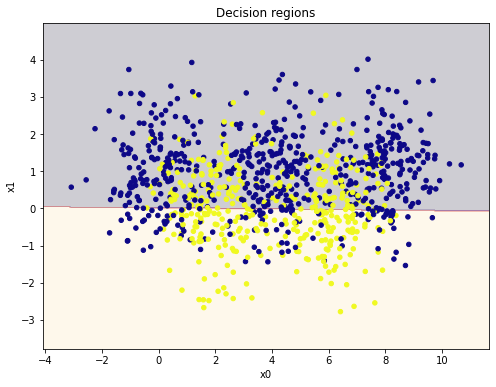

In [16]:
cl = NumpyLinRegClass()
cl.fit(X_train, t2_train)
plot_decision_regions(X_train, t2_train, cl)


### Loss
The linear regression classifier is trained with mean squared error loss. So far, we have not calculated the loss explicitly in the code. Extend the code to calculate the loss on the training set for each epoch and to store the losses such that the losses can be inspected after training. 

Train a classifier with your best settings from last point. After training, plot the loss as a function of the number of epochs.


 Accuracy for training set: 0.699

 Accuracy for validation set: 0.666

 Minimal epoch neccesary for given loss difference (test set): 173

 Minimal epoch neccesary for given loss difference (validation set): 130


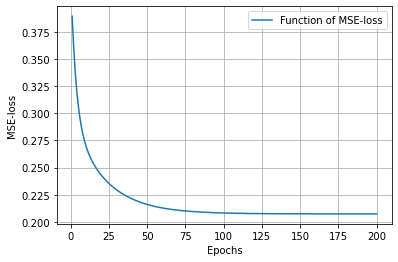

In [80]:
cl = NumpyLinRegClass()
fit, minimalE = cl.fit(X_train, t2_train)
fit2, minimalE2 = cl.fit(X_val, t2_val,)
accu1 = cl.accuracy(X_train, t2_train)
accu2 = cl.accuracy(X_val, t2_val)

print(f'\n Accuracy for training set: {accu1}')
print(f'\n Accuracy for validation set: {accu2}')
print(
    f'\n Minimal epoch neccesary for given loss difference (test set): {minimalE[0]}')
print(
    f'\n Minimal epoch neccesary for given loss difference (validation set): {minimalE2[0]}')


def plot_mseLoss(loss, end):

    plt.plot(np.linspace(1, end, end), loss[0: end], label="Function of MSE-loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE-loss")
    plt.legend()
    plt.grid()
    plt.show()

fit, minE2 = cl.fit(X_val, t2_val)

plot_mseLoss(fit, 200)


### Control training
The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the fit-method with a keyword argument, `loss_diff`, and stop training when the loss has not improved with more than loss_diff. Also add an attribute to the classifier which tells us after fitting how many epochs were ran.

In addition, extend the fit-method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to fit, calculate the loss for the validation set, and the accuracy for both the training set and the validation set for each epoch.

Train classifiers with the best value for learning rate so far, and with varying values for `loss_diff`. For each run report, `loss_diff`, accuracy and number of epochs ran.

After a succesful training, plot both training loss snd vslidation loss as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. Comment on what you see.

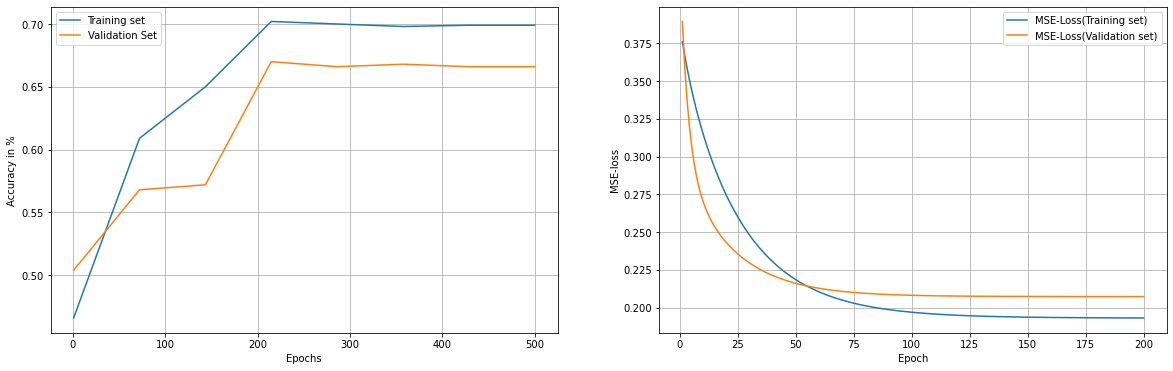

In [79]:
points = 200
max_epoch= 500
plot_acc1 = []
plot_acc2 = []
e_points = []
for e in [1, 10, 30, 100, 150, 200, 300, max_epoch]:
    cl = NumpyLinRegClass()
    fit1 = cl.fit(X_train, t2_train, epochs=e)
    fit2 = cl.fit(X_val, t2_val, epochs=e)
    e_points.append(e)
    plot_acc1.append(cl.accuracy(X_train, t2_train))
    plot_acc2.append(cl.accuracy(X_val, t2_val))

fig = plt.subplots(12, figsize=(20, 6))

plt.subplot(121)
plt.plot(np.linspace(min(e_points), max(e_points), len(e_points)), plot_acc1, label='Training set')
plt.plot(np.linspace(min(e_points), max(e_points), len(e_points)),
        plot_acc2, label='Validation Set')
plt.xlabel("Epochs")
plt.ylabel("Accuracy in %")
plt.grid()
plt.legend()

fit1, minE1 = cl.fit(X_train, t2_train)
fit2, minE2 = cl.fit(X_val, t2_val)

plt.subplot(122)
plt.plot(np.linspace(1, points, points), 
        fit1[0: points], label='MSE-Loss(Training set)')
plt.plot(np.linspace(1, points, points),
         fit2[0: points], label='MSE-Loss(Validation set)')
plt.ylabel("MSE-loss")
plt.xlabel("Epoch")
plt.grid()
plt.legend()

plt.show()


### Discussion

By the plot of the MSE loss one can observe that for both the training set and the validation set the linear regression classifier will for each epoch have a loss of $\frac{1}{e}$ where $e$ is the epoch. 

For the accuracy there seems to be a linear development up until its global maxima. For further analysis it could be reasonable to simulate more points, but could create a lot longer running times.

### Logistic regression
You should now do similarly for a logistic regression classifier. Calculate loss and accuracy for training set and, when provided, also for validation set.

Remember that logistic regression is trained with cross-entropy loss. Hence the loss function is calculated differently than for linear regression.

After a succesful training, plot both losses as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. 

Comment on what you see. Do you see any differences between the linear regression classifier and the logistic regression classifier on this dataset?

#### Starting point: Code from weekly 7

In [19]:
def logistic(x):
    return 1/(1+np.exp(-x))

In [20]:
def log_loss(y, y_pred):
    sum_errors = 0.
    for i in range(0,len(y)):
        sum_errors += - (y[i]*np.log(y_pred[i]) - ((1 - y[i])*np.log(1 - y_pred[i])))
    loss = sum_errors/len(y)
    return loss


In [23]:
class NumpyLogReg(NumpyClassifier):

    def fit(self, X_train, t_train, eta=0.13879310344827586, epochs=10, loss_Diff=1e-5):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
        
        (k, m) = X_train.shape
        X_train = add_bias(X_train)
        
        self.weights = weights = np.zeros(m+1)
        
        diff_log_loss = []
        min_Epochs = []
        for i in range(epochs): 
            weights -= eta / k * X_train.T @ (self.forward(X_train) - t_train)
            Error = log_loss(t_train, self.forward(X_train))
            diff_log_loss.append(Error)

            if abs(diff_log_loss[i-1] - diff_log_loss[i]) <= loss_Diff and i != 0:
                min_Epochs.append(i)
                
        return diff_log_loss
        
    def forward(self, X):
        return logistic(X @ self.weights)
    
    def score(self, x):
        z = add_bias(x)
        score = self.forward(z)
        return score
    
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = self.forward(z)
        return (score>threshold).astype('int')


In [24]:
eta_best, epoch_best, acc_best = 0, 0, 0

eta_values = np.linspace(0.001, 1, 30)

for eta in eta_values:
    for epoch in [1, 10, 20, 50, 60, 100]:
        log_cl = NumpyLogReg()
        log_cl.fit(X_train, t2_train, eta=eta, epochs=epoch)
        accu = log_cl.accuracy(X_val, t2_val)
        if accu > acc_best:
            acc_best = accu
            eta_best, epoch_best = eta, epoch

print(f'Eta: {eta_best}: Epochs: {epoch_best}: Accuracy: {acc_best}')

Eta: 0.13879310344827586: Epochs: 20: Accuracy: 0.678


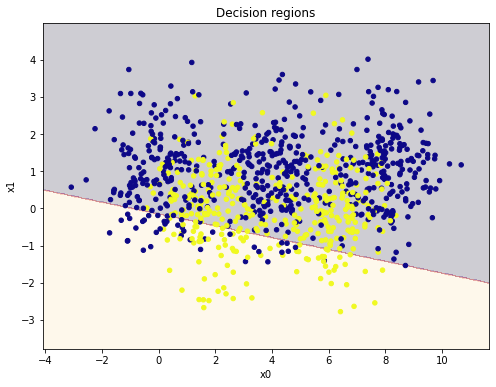

In [25]:
log_cl = NumpyLogReg()
log_cl.fit(X_train, t2_train)
plot_decision_regions(X_train, t2_train, log_cl)

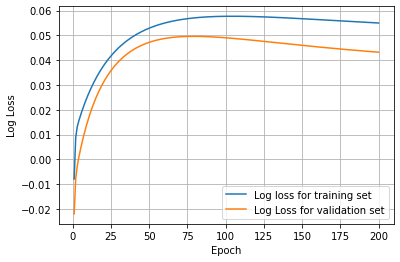

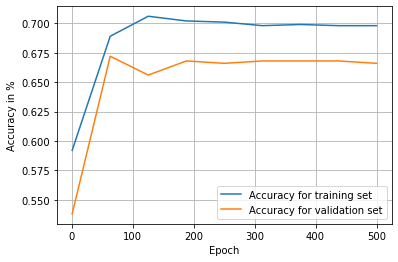

In [78]:
points = 200
def plot_mseLossLog(loss1, loss2):

    plt.plot(np.linspace(1, points, points), loss1[0: points], label='Log loss for training set')
    plt.plot(np.linspace(1, points, points), loss2[0: points], label="Log Loss for validation set")
    plt.xlabel("Epoch")
    plt.ylabel("Log Loss")
    plt.grid()
    plt.legend()
    plt.show()


log_cl = NumpyLogReg()
fit1 = log_cl.fit(X_train, t2_train, epochs=points)
fit2  = log_cl.fit(X_val, t2_val, epochs=points)
plot_mseLossLog(fit1, fit2)


def plot_accuracy(X_train, t_train, X_val, t_val, max_epoch=500):

    plot_acc1 = []
    plot_acc2 = []
    e_points = []
    for e in [1, 10, 30, 100, 150, 200, 250, 300, max_epoch]:
        log_cl = NumpyLogReg()
        fit1 = log_cl.fit(X_train, t_train, epochs=e)
        fit2 = log_cl.fit(X_val, t_val, epochs=e)
        e_points.append(e)
        plot_acc1.append(log_cl.accuracy(X_train, t_train))
        plot_acc2.append(log_cl.accuracy(X_val, t_val))

    plt.plot(np.linspace(min(e_points), max(e_points), len(e_points)),
             plot_acc1, label='Accuracy for training set')
    plt.plot(np.linspace(min(e_points), max(e_points), len(e_points)),
             plot_acc2, label='Accuracy for validation set')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy in %")
    plt.grid()
    plt.legend()
    plt.show()

plot_accuracy(X_train, t2_train, X_val, t2_val)


### Discussion

By both the plots of loss and accuracy of the logistic classifier there are some distinctions compared to the linear regression. First of all one can observe that the loss of both data sets follow a logarithmic development until it reaches its global maxima. Straight after it stars to descend in a converging matter and terminates for values close to zero (it might not be exactly zero since there might be rounding errors on the computer). 

Similar to the accuracy plot for linear regression the accuracy are seemingly linearly developing, but converges quite quickly relative to the first accuracy calculations (This could also be further analyzed with a lot more data points, but in this case I do not want to the program to run for many minutes). 

It is worth noting that for both the training and the validation set the converging accuracy is not the same as maximal accuracy which could be caused by the fact of over-fitting. 

## Multi-class classifiers
We turn to the task of classifying when there are more than two classes, and the task is to ascribe one class to each input. We will now use the set (X, t).

### "One-vs-rest" with logistic regression
We saw in the lecture how a logistic regression classifier can be turned into a multi-class classifier using the one-vs-rest approach. We train one logistic regression classifier for each class. To predict the class of an item, we run all the binary classifiers and collect the probability score from each of them. We assign the class which ascribes the highest probability.

Build such a classifier. Train the resulting classifier on (X_train, t_train), test it on (X_val, t_val), tune the hyper-parameters and report the accuracy.

Also plot the decision boundaries for your best classifier similarly to the plots for the binary case.

In [71]:
def fit(X_1, t_1, X_2, t_2):
    cumu_acc = []
    for i in range(0, max(t_1)+1):
        integer = np.vectorize(int)
        log_cl = NumpyLogReg()
        t_new_t = integer((t_1 == i))
        t_new_v = integer((t_2 == i))
        log_cl.fit(X_1, t_new_t, epochs=100)
        cumu_acc.append(log_cl.accuracy(X_2, t_new_v))
    return f'{np.mean(cumu_acc):.4f}'
fit(X_train, t_train, X_val, t_val)
#plot_decision_regions(X_train, t_train, log_cl)


'0.8460'

### For in4050-students: Multi-nominal logistic regression
The following part is only mandatory for in4050-students. In3050-students are also welcome to make it a try. Everybody has to return for the part 2 on multi-layer neural networks. 

In the lecture, we contrasted the one-vs-rest approach with the multinomial logistic regression, also called softmax classifier. Implement also this classifier, tune the parameters, and compare the results to the one-vs-rest classifier. (Don't expect a large difference on a simple task like this.)

Remember that this classifier uses exponetiation followed by softmax in the forward phase. For loss, it uses cross-entropy loss. The loss has a somewhat simpler form than in the binary case. To calculate the gradient is a little more complicated. The actual gradient and update rule is simple, however, as long as you have calculated the forward values correctly.

# Part II
## Multi-layer neural networks
We will implement the Multi-layer feed forward network (MLP, Marsland sec. 4.2.1), where we use mean squared loss together with logistic activation in both the hidden and the last layer.

Since this part is more complex, we will do it in two rounds. In the first round, we will go stepwise through the algorithm with the dataset (X, t). We will initialize the network and run a first round of training, i.e. one pass through the algorithm at p. 78 in Marsland.

In the second round, we will turn this code into a more general classifier. We can train and test this on (X, t) and (X, t2), but also on other datasets.

## Round 1: One epoch of training

### Scaling
First we have to scale our data. Make a standard scaler (normalizer) and scale the data. Remember, not to follow Marsland on this point. The scaler should be constructed from the training data only, but be applied both to training data and later on to validation and test data.

In [28]:
# Your code
x_min = np.min(X_train)
x_max = np.max(X_train)
X_scaled = (X_train - x_min)/(x_max - x_min)
print(X_scaled)


[[0.50363242 0.23699307]
 [0.78618838 0.30835372]
 [0.31410927 0.15659098]
 ...
 [0.30046871 0.35094144]
 [0.42928029 0.29061845]
 [0.50418405 0.11960543]]


### Initialization
We will only use one hidden layer. The number of nodes in the hidden layer will be a hyper-parameter provided by the user; let's call it *dim_hidden*. (*dim_hidden* is called *M* by Marsland.) Initially, we will set it to 3. This is a hyper-parameter where other values may give better results, and the hyper-parameter could be tuned.

Another hyper-parameter set by the user, is the learning rate. We set the initial value to 0.01, but also this may need tuning.

In [29]:
eta = 0.01 #Learning rate
dim_hidden = 3

We assume that the input *X_train* (after scaling) is a matrix of dimension *P x dim_in*, where *P* is the number of training instances, and *dim_in* is the number of features in the training instances (*L* in Marsland). Hence we can read *dim_in* off from *X_train*. 

The target values have to be converted from simple numbers, *0, 2,..* to "one-hot-encoded" vectors similarly to the multi-class task. After the conversion, we can read *dim_out* off from *t_train*. 

In [30]:
#Converting
dim_in =  X_train.shape[1]
dim_out = len(set(t))
t_train_new = np.eye(len(np.unique(t_train)))[t_train]
print(f'Dimension in: {dim_in}, Dimension out: {dim_out}')


Dimension in: 2, Dimension out: 5


Since we have Dim in = $2$, Dim out = 5 and Dim out = 3 it follows that:
$\begin{align*}
X \times \omega_1 \rightarrow (n, 3 + b) \\
H \times \omega_2 \rightarrow (n,5)
\end{align*}$

where H corresponds to the hidden activations and b to the bias (n is of course arbitrary).

We need two sets of weights: weights1 between the input and the hidden layer, and weights2, between the hidden layer and the output. Make sure that you take the bias terms into consideration and get the correct dimensions. The weight matrices should be initialized to small random numbers, not to zeros. It is important that they are initialized randomly, both to ensure that different neurons start with different initial values and to generate different results when you rerun the classifier. In this introductory part, we have chosen to fix the random state to make it easier for you to control your calculations. But this should not be part of your final classifier.

In [31]:
# Your code
# weights1 = np.random.rand(dim_in, dim_hidden)
# weights2 = np.random.rand(dim_hidden, dim_out)

# bias1 = np.zeros(dim_hidden)
# bias2 = np.zeros(dim_out)

#print(weights1.shape)

In [32]:
rng = np.random.RandomState(2022)
weights1 = (rng.rand(dim_in+1, dim_hidden+1) * 2 - 1)/np.sqrt(dim_in)
weights2 = (rng.rand(dim_hidden+1, dim_out) * 2 - 1)/np.sqrt(dim_hidden)


In [33]:
print(f'X_scaled shape: {X_scaled.shape}, X_train shape: {X_train.shape}, weights1 shape: {weights1.shape}, weights2 shape: {weights2.shape}')


X_scaled shape: (1000, 2), X_train shape: (1000, 2), weights1 shape: (3, 4), weights2 shape: (4, 5)


### Forwards phase
We will run the first step in the training, and start with the forward phase. Calculate the activations after the hidden layer and after the output layer. We will follow Marsland and use the logistic (sigmoid) activation function in both layers. Inspect whether the results seem reasonable with respect to format and values.

In [34]:
# Your code
X_scaled_bias = add_bias(X_scaled)
hidden_activations = logistic(X_scaled_bias @ weights1)
print(hidden_activations.shape)
print(hidden_activations[0, :])

(1000, 4)
[0.39441994 0.51587346 0.4619554  0.39612828]


In [35]:
# Your code
output_activations = logistic(hidden_activations @ weights2)
print(output_activations.shape)
print(output_activations[0, :])

(1000, 5)
[0.51620209 0.62143362 0.36155971 0.54620809 0.48221447]


To control that you are on the right track, you may compare your first output value with our result. We have put the bias term -1 in position 0 in both layers. If you have done anything differently from us, you will not  get the same numbers. But you may still be on the right track!

In [36]:

#array([0.28969058, 0.44120276, 0.41012141, 0.38135763, 0.44130415])


### Backwards phase
Calculate the delta terms at the output. We assume, like Marsland, that we use sum of squared errors. (This amounts to the same as using the mean square error).

In [37]:
# Your code
delta_error = (output_activations - t_train_new) * output_activations*(1-output_activations)


Calculate the delta terms in the hidden layer.

In [38]:
delta_hidden_error = hidden_activations *(1 - hidden_activations)*(delta_error @ weights2.T)

print(f'Delta 0: {delta_error.shape}, Delta Hidden: {delta_hidden_error.shape}')


Delta 0: (1000, 5), Delta Hidden: (1000, 4)


Update the weights in both layers.. See whether the weights have changed.

In [39]:
# between input and the hidden layer
tmp_weight1 = weights1.copy()
tmp_weight2 = weights2.copy()

weights1 -= eta * (X_scaled_bias.T @ delta_hidden_error)
# between hidden layer and the output
weights2 -= eta * (hidden_activations.T @ delta_error)

print(weights1 - tmp_weight1)
print(weights2- tmp_weight2)


[[-0.15045562 -0.13733905 -0.05524592  0.11838113]
 [-0.10004346 -0.10195062 -0.03318186  0.06123651]
 [-0.0374728  -0.03697086 -0.0196239   0.03100159]]
[[-0.32782827 -0.38444462 -0.13189544 -0.35757397 -0.28732173]
 [-0.41413489 -0.49914003 -0.18450637 -0.45521136 -0.37627614]
 [-0.39368477 -0.45065644 -0.14603637 -0.42268345 -0.33085559]
 [-0.32692324 -0.38534791 -0.13433109 -0.35678478 -0.28820772]]


As an aid, you may compare your new weights with our results. But again, you may have done everything correctly even though you get a different result. For example, there are several ways to introduce the mean squared error. They may give different results after one epoch. But if you run sufficiently many epochs, you will get about the same classifier.

In [40]:
print("New weights:")
print(weights1)

New weights:
[[-0.84432732 -0.13867151 -0.60200395 -0.51805172]
 [ 0.16216247 -0.12035227  0.52919038  0.26976523]
 [ 0.52391783  0.27576116  0.4489806   0.49425279]]


##  Step 2: A Multi-layer neural network classifier
### Make the classifier

You want to train and test a classifier on (X, t). You could have put some parts of the code in the last step into a loop and run it through some iterations. But instead of copying code for every network we want to train, we will build a general Multi-layer neural network classfier as a class. This class will have some of the same structure as the classifiers we made for linear and logistic regression. The task consists mainly in copying in parts from what you did in step 1 into the template below. Remember to add the *self*- prefix where needed, and be careful in your use of variable names. And don't fix the random numbers within the classifier.

In [41]:
class MNNClassifier():
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self,eta = 0.01, dim_hidden = 3):
        """Initialize the hyperparameters"""
        self.eta = eta
        self.dim_hidden = dim_hidden

        # Should you put additional code here?
        
    def fit(self, X_train, t_train, epochs = 100):
        """Initialize the weights. Train *epochs* many epochs."""
        
        # Initilaization
        # Fill in code for initalization
        
        self.dim_in = dim_in =  X_train.shape[1]
        self.dim_out = dim_out = len(set(t_train))

        rng = np.random.RandomState(2022)
        #Could also use RandomState of time.time() to make it even more random

        self.weights1 = (rng.rand(dim_in+1, dim_hidden+1) * 2 - 1)/np.sqrt(dim_in)
        self.weights2 = (rng.rand(dim_hidden+1, dim_out) * 2 - 1)/np.sqrt(dim_hidden)

        self.t_train_new = t_train_new = np.eye(
            len(np.unique(t_train)))[t_train]

        self.X_t_bias = X_t_bias = add_bias(X_train, n=-1)
        
        for _ in range(epochs):
            # Run one epoch of forward-backward
            self.hidden_activations, self.output_activations = self.forward(
                X_t_bias)
            self.backward(X_t_bias)
            #Fill in the code


            
    def forward(self, X):
        """Perform one forward step. 
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        #Fill in the code
        weights1 = self.weights1
        weights2 = self.weights2

        hidden_activations = logistic(X @ weights1)
        output_activations = logistic(hidden_activations @ weights2)

        return hidden_activations, output_activations
        
    def backward(self, X):
        hidden_activations, output_activations = self.hidden_activations, self.output_activations

        delta0 = (output_activations - self.t_train_new) * \
            output_activations*(1-output_activations)
        delta_hidden = hidden_activations * \
            (1 - hidden_activations)*(delta0 @ self.weights2.T)

        self.weights1 -= eta*(X.T @ delta_hidden)
        self.weights2 -= eta*(hidden_activations.T@delta0)
        
    def accuracy(self, X_test, t_test):
        """Calculate the accuracy of the classifier for the pair (X_test, t_test)
        Return the accuracy"""
        #Fill in the code
        X_test_bias = add_bias(X_test, n=-1)
        hid, out = self.forward(X_test_bias)
        predicted = np.argmax(out, axis=1)
        acc = np.sum(predicted == t_test)
        return acc / len(t_test)
        
    def predict(self, X):
        """Predict the value for the item x"""
        _, prediction = self.forward(add_bias(X, n=-1))
        return np.argmax(prediction, axis=1)


### Multi-class
Train the network on (X_train, t_train) (after scaling), and test on (X_val, t_val). Tune the hyperparameters to get the best result:
- number of epochs
- learning rate
- number of hidden nodes.

When you are content with the hyperparameters, you should run the same experiment 10 times, collect the accuracies and report the mean value and standard deviation of the accuracies across the experiments. This is common practise when you apply neural networks as the result may vary slightly between the runs. You may plot the decision boundaries for one of the runs.

Discuss shortly how the results and decsion boundaries compare to the "one-vs-rest" classifier.

In [42]:
def scale_MNN(X):
    x_max = np.max(X)
    x_min = np.min(X)
    X_train_scaled = (X - x_min)/(x_max - x_min)
    return X_train_scaled

accu_list = []
best_accu_list = []

poss_eta = [0.1, 0.025, 0.015, 0.005, 0.001]
dim_hidden_num = [3, 6, 9, 12, 15]
epochs = [50, 100, 300, 500, 1000, 5000]

best_eta = poss_eta[0]
best_dim_hidden = dim_hidden_num[0]
best_epoch = epochs[0]
best_accu = 0
for eta in poss_eta:
    for dim_hidden in dim_hidden_num:
        for epoch in epochs:
            mnn = MNNClassifier(eta=eta, dim_hidden=dim_hidden)
            mnn.fit(scale_MNN(X_train), t_train, epochs=epoch)
            accu = mnn.accuracy(scale_MNN(X_val), t_val)
            accu_list.append(accu)
            if accu > best_accu:
                best_epoch = epoch
                best_dim_hidden = dim_hidden
                best_eta = eta 
                # print(f'Eta: {best_eta}, Hidden dimension: {best_dim_hidden}, Epochs: {best_epoch}, Accuracy: {accu}')
for _ in range(10):
    mnn = MNNClassifier(eta=best_eta, dim_hidden=best_dim_hidden)
    mnn.fit(scale_MNN(X_train), t_train, epochs=best_epoch)
    accu = mnn.accuracy(scale_MNN(X_val), t_val)
    best_accu_list.append(accu)
    
print(f'\n Best accuracy: {max(accu_list)}, Best eta: {best_eta}, Best hidden dimension: {best_dim_hidden}, Best epochs: {best_epoch}')
print(f'\n Mean Accuracy: {np.mean(best_accu_list)}')
print(f'\n Standard Deviation: {np.std(best_accu_list):.5f}')



 Best accuracy: 0.772, Best eta: 0.001, Best hidden dimension: 15, Best epochs: 5000

 Mean Accuracy: 0.752

 Standard Deviation: 0.00000


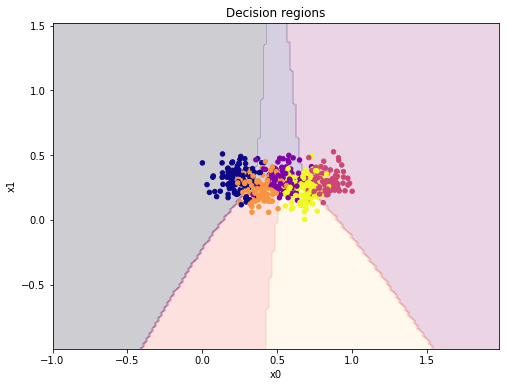

In [77]:
MNN = MNNClassifier()
MNN.fit(scale_MNN(X_train), t_train, epochs=best_epoch)
plot_decision_regions(scale_MNN(X_val), t_val, MNN)

### Discussion 
We observe that from both hyperparameter values and the decision boundary plot that accuracy is well above average. It is not fully optimal, but mostly due to the not so ideal separability of the data set. Compared to the One Vs Rest it is quite similar, but varies by some percents. This might in many instances change relative to the data set (depending upon if its generic or synthetic).

### Binary class
Let us see whether a multilayer neural network can learn a non-linear classifier.
Train a classifier on (X_train, t2_train) and test it on (X_val, t2_val).
Tune the hyper-parameters for the best result. Run ten times with the best setting and report mean and standard deviation. Plot the decision boundaries.

In [75]:

accu_list_2 = []
best_accu_list_2 = []

poss_eta_2 = [0.1, 0.025, 0.015, 0.005, 0.001]
dim_hidden_num_2 = [3, 6, 9, 12, 15]
epochs_2 = [50, 100, 300, 500, 1000, 5000]

best_eta_2 = poss_eta_2[0]
best_dim_hidden_2 = dim_hidden_num_2[0]
best_epoch_2 = epochs_2[0]
best_accu_2 = 0

for eta in poss_eta_2:
    for dim_hidden in dim_hidden_num_2:
        for epoch in epochs_2:
            mnn = MNNClassifier(eta=eta, dim_hidden=dim_hidden)
            mnn.fit(scale_MNN(X_train), t2_train, epochs=epoch)
            accu = mnn.accuracy(scale_MNN(X_val), t2_val)
            accu_list_2.append(accu)
            if accu > best_accu_2:
                best_epoc_2 = epoch
                best_dim_hidden_2 = dim_hidden
                best_eta_2 = eta
                # print(f'Eta: {best_eta}, Hidden dimension: {best_dim_hidden}, Epochs: {best_epoch}, Accuracy: {accu}')
for _ in range(10):
    mnn = MNNClassifier(eta=best_eta, dim_hidden=best_dim_hidden)
    mnn.fit(scale_MNN(X_train), t2_train, epochs=best_epoch)
    accu = mnn.accuracy(scale_MNN(X_val), t2_val)
    best_accu_list_2.append(accu)
print(
    f'\n Best accuracy: {max(accu_list_2)}, Best eta: {best_eta_2}, Best hidden dimension: {best_dim_hidden_2}, Best epochs: {best_epoch_2}')
print(f'\n Mean Accuracy: {np.mean(best_accu_list_2)}')
print(f'\n Standard Deviation: {np.std(best_accu_list_2):.5f}')



 Best accuracy: 0.784, Best eta: 0.001, Best hidden dimension: 15, Best epochs: 50

 Mean Accuracy: 0.6639999999999999

 Standard Deviation: 0.00000


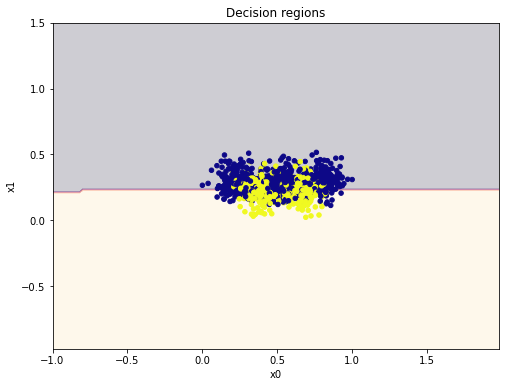

In [76]:
mnn = MNNClassifier(eta=best_eta, dim_hidden=best_dim_hidden)
mnn.fit(scale_MNN(X_train), t2_train, epochs=best_epoch)

plot_decision_regions(scale_MNN(X_train), t2_train, mnn)


## For in4050-students: Early stopping
The following part is only mandatory for in4050-students. In3050-students are also welcome to make it a try. Everybody has to return for the part 2 on multi-layer neural networks. 

There is a danger of overfitting if we run too many epochs of training. One way to control that is to use early stopping. We can use (X_val, t_val) as valuation set when training on (X_train, t_train).

Let *e=50* or *e=10* (You may try both or choose some other number) After *e* number of epochs, calculate the loss for both the training set (X_train, t_train) and the validation set (X_val, t_val), and store them.

Train a classifier for many epochs. Plot the losses for both the training set and the validation set in the same figure and see whether you get the same effect as in figure 4.11 in Marsland.

Modify the code so that the training stops if the loss on the validation set is not reduced by more than *t* after *e* many epochs, where *t* is a threshold you provide as a parameter. 

Run the classifier with various values for *t* and report the accuracy and the numberof epochs ran.

# Part III: Final testing
We can now perform a final testing on the held-out test set.

## Binary task (X, t2)
Consider the linear regression classifier, the logistic regression classifier and the multi-layer network with the best settings you found. Train each of them on the training set and evaluate on the held-out test set, but also on the validation set and the training set. Report in a 3 by 3 table.

Comment on what you see. How do the three different algorithms compare? Also, compare the result between the different data sets. In cases like these, one might expect slightly inferior results on the held-out test data compared to the validation data. Is so the case? 

Also report precision and recall for class 1.

## Multi-class task (X, t)
For IN3050 students compare the one-vs-rest classifier to the multi-layer preceptron. Evaluate on test, validation and training set as above. In4050-students should also include results from the multi-nomial logistic regression.

Comment on the results.

In [72]:
from tabulate import tabulate

def scaled(X):
    x_min = np.min(X)
    x_max = np.max(X)
    X_scaled = (X - x_min)/(x_max - x_min)
    return X_scaled
    
#Linear Regression Classifier

lin = NumpyLinRegClass()
lin.fit(scaled(X_train), t2_train, epochs=best_epoch)
acc_lin_train = lin.accuracy(scaled(X_train), t2_train)
acc_lin_val = lin.accuracy(scaled(X_val), t2_val)
acc_lin_test = lin.accuracy(scaled(X_test), t2_test)

# Logistic classifier 
log = NumpyLogReg()
log.fit(scaled(X_train), t2_train, epochs=100)
acc_log_train = log.accuracy(scaled(X_train), t2_train)
acc_log_val = log.accuracy(scaled(X_val), t2_val)
acc_log_test = log.accuracy(scaled(X_test), t2_test)

# Multi Layer network

MNN = MNNClassifier(eta=0.01, dim_hidden=6)
MNN.fit(scaled(X_train), t2_train, epochs=best_epoch)
acc_MNN_train = MNN.accuracy(scaled(X_train), t2_train)
acc_MNN_val = MNN.accuracy(scaled(X_val), t2_val)
acc_MNN_test = MNN.accuracy(scaled(X_test), t2_test)

results = [["X_train", acc_lin_train, acc_log_train, acc_MNN_train],
           ["X_val", acc_lin_val, acc_log_val, acc_MNN_val],
           ["X_test", acc_lin_test, acc_log_test, acc_MNN_test]]
col_names = ["Data set", "Linear Reg", "Logistic Reg", "Multi-Layer Network"]

print("Accuracy for given learning models using the binary class set (t_2):")
print(tabulate(results, headers=col_names, tablefmt="fancy_grid"))


MNN = MNNClassifier(eta=0.01, dim_hidden=6)
MNN.fit(scaled(X_train), t_train, epochs=best_epoch)
acc_MNN_train = MNN.accuracy(scaled(X_train), t_train)
acc_MNN_val = MNN.accuracy(scaled(X_val), t_val)
acc_MNN_test = MNN.accuracy(scaled(X_test), t_test)

acc_OvR_train = fit(scaled(X_train), t_train, scaled(X_train), t_train)
acc_OvR_val = fit(scaled(X_train), t_train, scaled(X_val), t_val)
acc_OvR_test = fit(scaled(X_train), t_train, scaled(X_test), t_test)
results2 = [["X_train", acc_OvR_train, acc_MNN_train],
           ["X_val", acc_OvR_val, acc_MNN_val],
           ["X_test", acc_OvR_test,acc_MNN_test]]
col_names2 = ["Data set", "One vs Rest", "Multi-Layer Network"]

print("Accuracy for given learning models using the multi class set (t):")
print(tabulate(results2, headers=col_names2, tablefmt="fancy_grid"))


Accuracy for given learning models using the binary class set (t_2):
╒════════════╤══════════════╤════════════════╤═══════════════════════╕
│ Data set   │   Linear Reg │   Logistic Reg │   Multi-Layer Network │
╞════════════╪══════════════╪════════════════╪═══════════════════════╡
│ X_train    │        0.709 │          0.614 │                 0.706 │
├────────────┼──────────────┼────────────────┼───────────────────────┤
│ X_val      │        0.672 │          0.572 │                 0.664 │
├────────────┼──────────────┼────────────────┼───────────────────────┤
│ X_test     │        0.722 │          0.6   │                 0.724 │
╘════════════╧══════════════╧════════════════╧═══════════════════════╛
Accuracy for given learning models using the multi class set (t):
╒════════════╤═══════════════╤═══════════════════════╕
│ Data set   │   One vs Rest │   Multi-Layer Network │
╞════════════╪═══════════════╪═══════════════════════╡
│ X_train    │           0.8 │                 0.76  │
├─────

### Solution: 

From the given tables one can observe that the levels of accuracy between the linear regression and the Multi layer perceptron is quite similar. This might be due to the fact that the learning rate in the linear regression classifier is quite optimal relative to how the data set is structured. And since the multi layer perceptron acts like a linear classifier, the accuracy values for the binary class set will in many instances turn out to be the same as for the linear regression since both the loss and the predictions of data points are done in a similar manner. 

When it comes to logistic regression there might be several reasons to why it comes a bit short on the binary class set. One might be the fact that the data set is not fit to be categorized, meaning there are no simple labels to categorize the given data points into. And since the data is not well separated either there might be several data points whom are on the border of separation resulting in the classifier sometimes labeling right and othertimes wrong.

For the multiclass instace there are certainly observations of improvement. As mentioned I could not fully work out how to make a One Vs Rest classifier, but even so there are clear signs of improvement regarding the logistic classifier. This is mostly due to, as written over, the fact that there are more data points too classify into several categories. When one has several categories it is simpler to split data with distinct labels into categories. Thus will the logistic classfier prevail in more cases than for for a simple (0, 1 or yes or no). 

Lastly it is worth mentioning that every classifier did better on the test sets than any of the other sets. This might be due to the fact that the classifiers are trained well with somewhat optimal hyperparameters and that the test set is more or less well designed to be classified.